In [1]:
import xarray
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from pyecharts import options as opts
from pyecharts.charts import Geo, Scatter
from pyecharts.globals import ChartType, SymbolType
import seaborn as sns



In [2]:
def generate_daily_dates(start_time, end_time):
    start_datetime = datetime.strptime(start_time, '%Y%m%d')
    end_datetime = datetime.strptime(end_time, '%Y%m%d')

    date_sequence = []
    current_datetime = start_datetime 
    while current_datetime <= end_datetime:
        date_sequence.append(datetime.strftime(current_datetime, '%Y%m%d'))
        current_datetime += timedelta(days=1)

    return date_sequence




In [17]:
fn = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/station"
station_file = "2628A.csv"
df1 = pd.read_csv(os.path.join(fn,station_file),index_col = False)
station= pd.read_csv('./station/station_name.csv')
station[station['监测点编码']=="2628A"]
df1.columns

Index(['datetime', 'AQI', 'PM2.5', 'PM2.5_24h', 'PM10', 'PM10_24h', 'SO2',
       'SO2_24h', 'NO2', 'NO2_24h', 'O3', 'O3_24h', 'O3_8h', 'O3_8h_24h', 'CO',
       'CO_24h'],
      dtype='object')

In [4]:
df = df1.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

def find_missing_periods(df, column, min_hours=12):
    # 重采样到每小时
    df_resampled = df.resample('h').mean()
    
    # 计算缺失值
    missing = df_resampled[column].isna()
    
    # 找到缺失值的连续时段
    missing_periods = missing.groupby((missing != missing.shift()).cumsum()).cumsum()
    
    # 找到连续缺失的时段
    missing_intervals = []
    for name, group in missing.groupby((missing != missing.shift()).cumsum()):
        if group.any():
            start_time = group.index[0]
            end_time = group.index[-1]
            duration = (end_time - start_time).total_seconds() / 3600
            if duration >= min_hours:
                missing_intervals.append((start_time, end_time, duration))
    
    return missing_intervals

# 查找'PM2.5'列的连续缺失段
missing_periods = find_missing_periods(df, 'PM2.5', min_hours=12)
for start, end, duration in missing_periods:
    print(f"缺失段: 从 {start} 到 {end}, 持续时间: {duration:.1f}小时")

缺失段: 从 2018-06-28 00:00:00 到 2018-06-28 14:00:00, 持续时间: 14.0小时
缺失段: 从 2018-08-04 21:00:00 到 2018-08-05 16:00:00, 持续时间: 19.0小时
缺失段: 从 2018-08-24 16:00:00 到 2018-08-25 06:00:00, 持续时间: 14.0小时
缺失段: 从 2018-08-26 04:00:00 到 2018-08-27 06:00:00, 持续时间: 26.0小时
缺失段: 从 2018-08-28 04:00:00 到 2018-08-29 06:00:00, 持续时间: 26.0小时
缺失段: 从 2018-08-30 01:00:00 到 2018-08-31 08:00:00, 持续时间: 31.0小时
缺失段: 从 2018-09-01 04:00:00 到 2018-09-01 23:00:00, 持续时间: 19.0小时
缺失段: 从 2018-10-11 01:00:00 到 2018-10-11 17:00:00, 持续时间: 16.0小时
缺失段: 从 2018-12-21 19:00:00 到 2018-12-27 16:00:00, 持续时间: 141.0小时
缺失段: 从 2019-01-23 22:00:00 到 2019-01-24 12:00:00, 持续时间: 14.0小时
缺失段: 从 2019-01-24 20:00:00 到 2019-01-25 11:00:00, 持续时间: 15.0小时
缺失段: 从 2019-02-13 19:00:00 到 2019-02-14 20:00:00, 持续时间: 25.0小时
缺失段: 从 2019-02-17 02:00:00 到 2019-02-18 21:00:00, 持续时间: 43.0小时
缺失段: 从 2019-02-20 07:00:00 到 2019-02-20 23:00:00, 持续时间: 16.0小时
缺失段: 从 2019-03-01 01:00:00 到 2019-03-02 13:00:00, 持续时间: 36.0小时
缺失段: 从 2019-03-02 17:00:00 到 2019-03-03 14:00:00, 持续时间

In [5]:

fn = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/station"
station = os.listdir(fn)
threshold = 15
out = []
for sta in station:
    df = pd.read_csv(os.path.join(fn,sta),index_col = False)
    # 计算每个变量的缺失值数量
    missing_counts = df.isnull().sum()

    # 计算缺失率
    total_rows = len(df)
    missing_rates = (missing_counts / total_rows) * 100
    if((missing_rates > threshold).any()):
        out.append(sta)
print(len(out),out)
   

480 ['1274A.csv', '2372A.csv', '1986A.csv', '1974A.csv', '1703A.csv', '1454A.csv', '1045A.csv', '1138A.csv', '1355A.csv', '1391A.csv', '2623A.csv', '2885A.csv', '2198A.csv', '1007A.csv', '3140A.csv', '2600A.csv', '1058A.csv', '1837A.csv', '1388A.csv', '1967A.csv', '1333A.csv', '2425A.csv', '2653A.csv', '1780A.csv', '3020A.csv', '2439A.csv', '1184A.csv', '1277A.csv', '1777A.csv', '1144A.csv', '1693A.csv', '1142A.csv', '1150A.csv', '1803A.csv', '1712A.csv', '1330A.csv', '1647A.csv', '1003A.csv', '2632A.csv', '1423A.csv', '1014A.csv', '1385A.csv', '1871A.csv', '1821A.csv', '2304A.csv', '2539A.csv', '2324A.csv', '1559A.csv', '1005A.csv', '1270A.csv', '2017A.csv', '2478A.csv', '1101A.csv', '2243A.csv', '1139A.csv', '2361A.csv', '2360A.csv', '1146A.csv', '1976A.csv', '1219A.csv', '1513A.csv', '1683A.csv', '1490A.csv', '1458A.csv', '2276A.csv', '1069A.csv', '2388A.csv', '1198A.csv', '2630A.csv', '3153A.csv', '1322A.csv', '1804A.csv', '1083A.csv', '2440A.csv', '1606A.csv', '2463A.csv', '1085A.

In [6]:

# 将 xarray.Dataset 转换为 pandas.DataFrame
df1 = df.copy()

# 需要绘制箱线图的特征列表
features = ['AQI', 'PM2.5', 'PM10',  
            'SO2', 'NO2',  'O3',  'CO', ]

# 初始化一个字典来存储每个特征的异常值数量
outlier_counts = {}

# 遍历每个特征，计算异常值数量
for col in features:
    # 计算Q1（第25百分位数）和Q3（第75百分位数）
    Q1 = np.percentile(df[col].dropna(), 25)
    Q3 = np.percentile(df[col].dropna(), 75)
    IQR = Q3 - Q1
    
    # 定义异常值的范围
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 计算异常值的数量
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# 打印每个特征中的异常值数量
print("Each feature's outlier count:")
for feature, count in outlier_counts.items():
    print(f"{feature}: {count}")



Each feature's outlier count:
AQI: 657
PM2.5: 664
PM10: 470
SO2: 689
NO2: 61
O3: 8
CO: 199


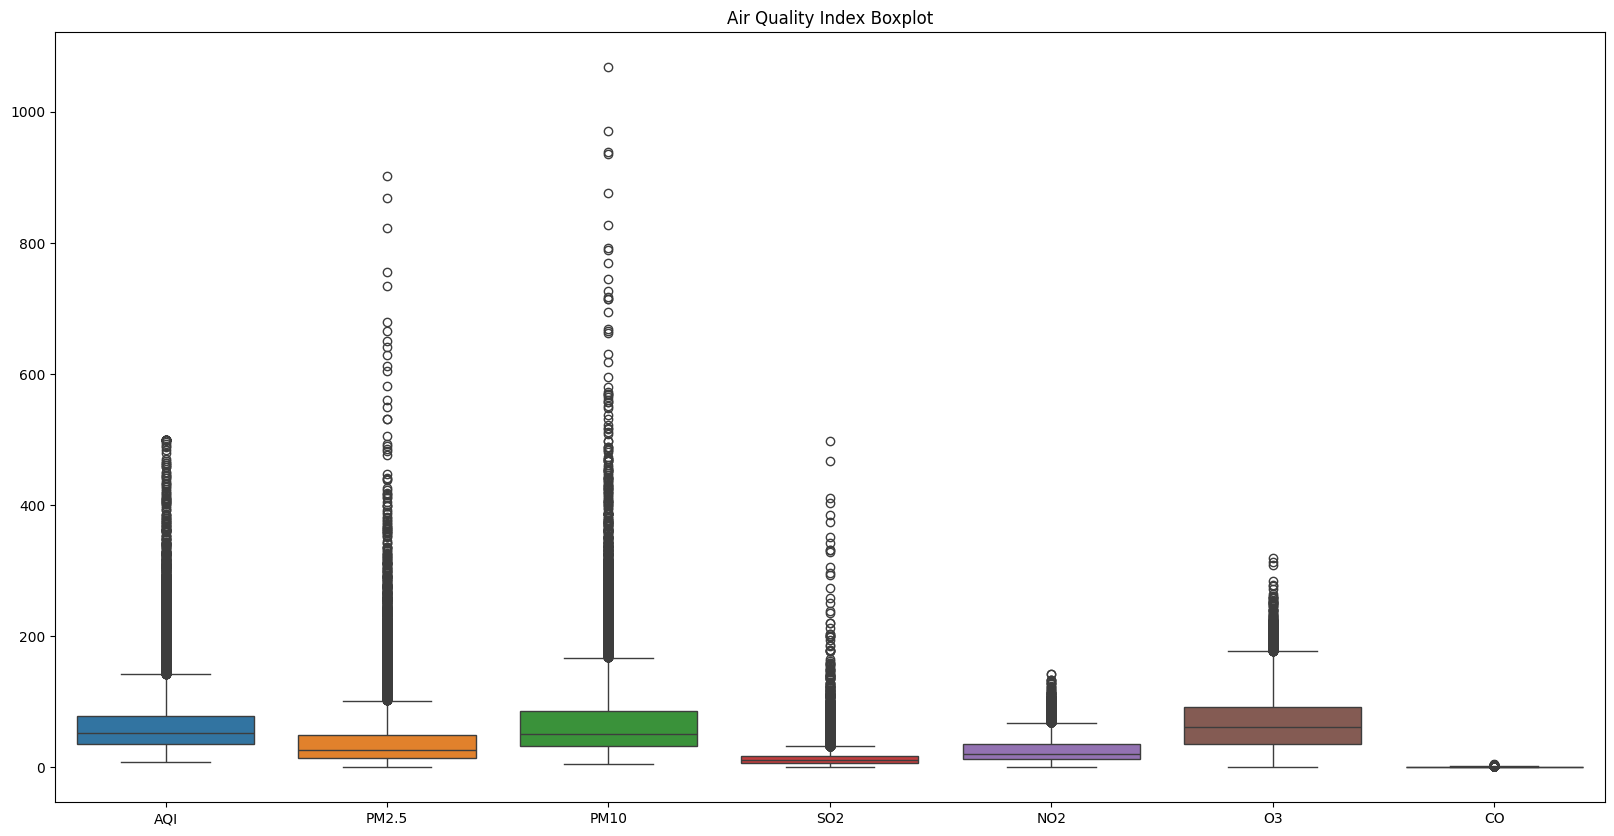

In [7]:

df1 = df.copy()
# 选择要绘制的列
features = ['AQI', 'PM2.5', 'PM10',  
            'SO2', 'NO2',  'O3',  'CO', ]
data = df1[features]
# 绘制箱线图
plt.figure(figsize=(20, 10))
sns.boxplot(data=data)
plt.title("Air Quality Index Boxplot")
plt.show()


In [8]:
'''
nearest: 使用最近的有效值进行插值。
zero: 阶梯插值。
slinear: 线性插值，与 linear 类似。
quadratic: 二次插值。
cubic: 三次插值。
polynomial: 多项式插值，可以指定 order 参数来控制多项式的阶数。
spline: 样条插值，可以通过 order 参数指定样条的阶数。
barycentric: 重心插值。
krog: Kriging 插值，适用于不规则网格。
pchip: 分段三次 Hermite 多项式插值。
akima: Akima 插值，用于不规则数据。
'''
ds_ins = df.interpolate_na(dim='hour', method='slinear')
start_time = pd.Timestamp('2019-01-01 00:00:00')
# end_time  = start_time + pd.Timedelta(hours=144)
# print(end_time)
time_list = [start_time + pd.Timedelta(days = h) for h in range(0,6)]
ds_fore = ds_ins.sel(time = time_list)
steps = range(0,144)
plt.figure(figsize=(12, 6))
plt.plot(range(0,144),ds_fore['CO'].values.flatten(), label='CO')
plt.xticks(range(0,144,6))
plt.grid(True)
plt.legend()
plt.show()
ds_fore

AttributeError: 'DataFrame' object has no attribute 'interpolate_na'

缺失值处理
对于缺失值常用的几种处理方式有：

* 删除缺失值：仅适用于缺失数量很少的情况  
填充缺失值：
数值变量：
   * 均值填充 ：mean
   * 中值填充 ：median
类别变量：
   * 众数填充 ：mode
   * 单独作为一个类别

* 其他填充方法：
   * 前向填充：ffill
   * 后向填充：bfill
   * 常值填充

缺失数据填补法细分为替换缺失值、拟合缺失值以及多重插补法三种  
替换缺失值的方法又名简单填充法，是一种常见且易行的缺失值填补方式    
1）使用均值、中位数或众数。当数据为数值型时，可以采用均值或众数填充  
2）热卡填充法，也称就近补齐法，它是一种使用缺失记录最相似的记录对其进行填补的方法，热卡填充法可以视为一种特殊的 KNN 方法。与 KNN 算法相同，相似性的定义方法直接影响了热卡填充法的性能  
3)拟合法主要包含对缺失值进行回归预测、随机森林预测以及极大似然估计等方法。回归预测法主要是根据数据集中的已有数据训练回归模型，而后使用该模型对缺失值进行预测，仅适用于变量之间存在线性关系的情况  
4)多重插补法是指通过已观测数据建立多个插值函数并用它们分别估计待插补值，这样就形成了多个模拟数据集。在选择最佳插补值时，考虑使模型评分最高的数据集对应的插补方法。


* 异常值检测
  * 箱形图
  * 3σ原则

* 异常值检测 
  * 3σ方式
  * 使用箱线图辅助
  * 相关异常检测算法

In [13]:
def get_var_mean(city,var):
    df = pd.read_csv(f"/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/station/{city}.csv")
    mean = df[var].mean()
    return mean
get_var_mean("1147A",'O3')

74.56720854057988

In [18]:

from pyecharts.charts import Geo
from pyecharts import options as opts
from pyecharts.globals import SymbolType
var = "O3"
data = pd.read_csv('./station/station_name.csv')
station_file= os.listdir("/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/station")
station = [item.split('.')[0] for item in station_file]
data = data[data['监测点编码'].isin(station)]
    # df[df['监测点编码'].isin(desired_codes)]
    # 提取经纬度数据并用城市作为名称
locations = [
    [city, lng, lat]
    for city, lng, lat in zip(data['监测点编码'], data['经度'], data['纬度'])
]

L = [ get_var_mean(city,var) for city, lng, lat in locations ]
L = sorted(L)
print(L[0],L[-1])
    # 提取站点名称和对应的比率
data_pair = [(city, get_var_mean(city,var)) for city, lng, lat in locations ]

    # 创建 Geo 图表
geo = Geo()
geo.add_schema(maptype="china")
# 添加自定义坐标
for key, lng, lat in locations:
    geo.add_coordinate(key, lng, lat)

    # 添加数据点
geo.add('', data_pair, symbol_size=7, itemstyle_opts=opts.ItemStyleOpts(color="red"))

    # 配置系列选项和全局选项
geo.set_series_opts(label_opts=opts.LabelOpts(is_show=False), type='scatter')
geo.set_global_opts(
    visualmap_opts=opts.VisualMapOpts(max_=L[-2],min_=L[2]),  
    title_opts=opts.TitleOpts(title=f"{var} level average"),
        
    )

# 渲染或展示图表

# # 渲染到 HTML 文件
geo.render(f"geo_chart-{var}.html")
# PM2.5  max_=80,min_=11
# O3  max_=100,min_=40
geo.render_notebook()

40.97398383937316 110.63747640216796


In [8]:
# 数据分布情况
station_list = ["1147A","1106A","1953A","1048A"]
fn = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/public/ShiXiSheng/zx/station"
station= pd.read_csv('./station/station_name.csv',index_col=False)
station[station['监测点编码'].isin(station_list)]

,Unnamed: 0,监测点编码,监测点名称,城市,经度,纬度
780,780,1147A,静安监测站,上海,121.4250,31.2261
1169,1169,1048A,东污水处理厂,邯郸,114.5426,36.6164
1707,1707,1953A,白碱滩区,克拉玛依,85.1186,45.6886
1827,1827,1106A,太原街,沈阳,123.3997,41.7972


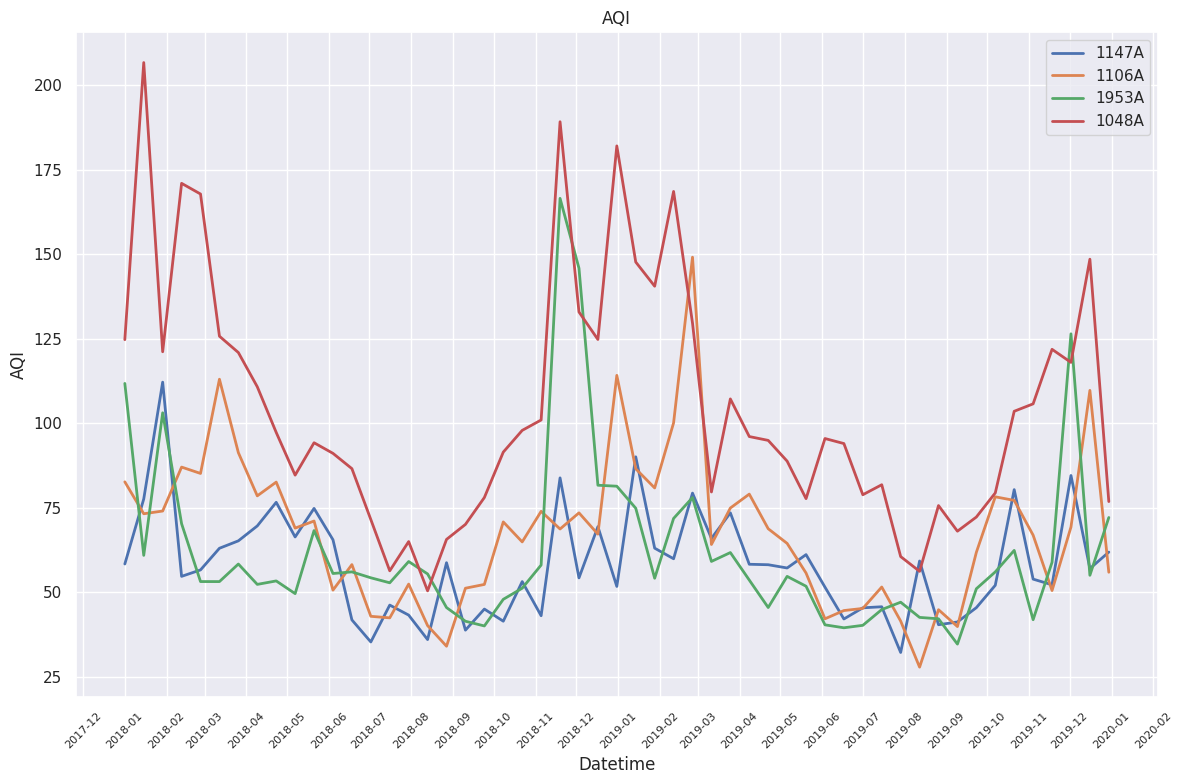

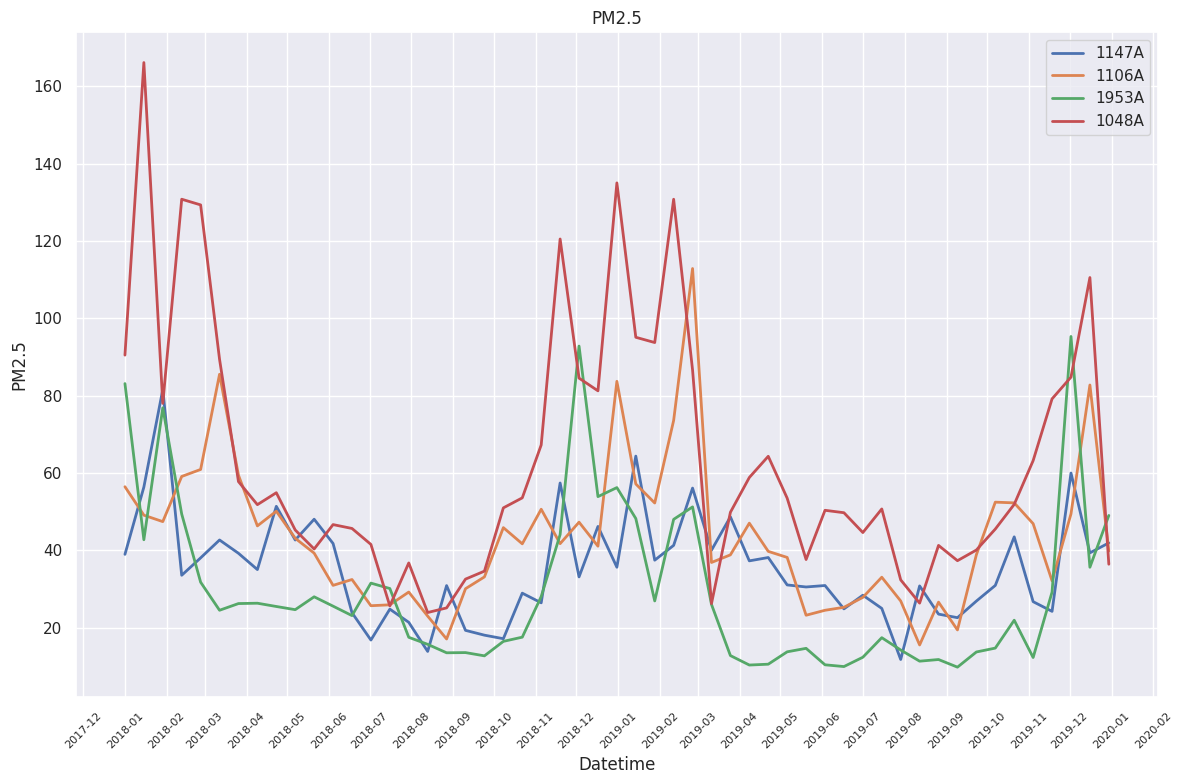

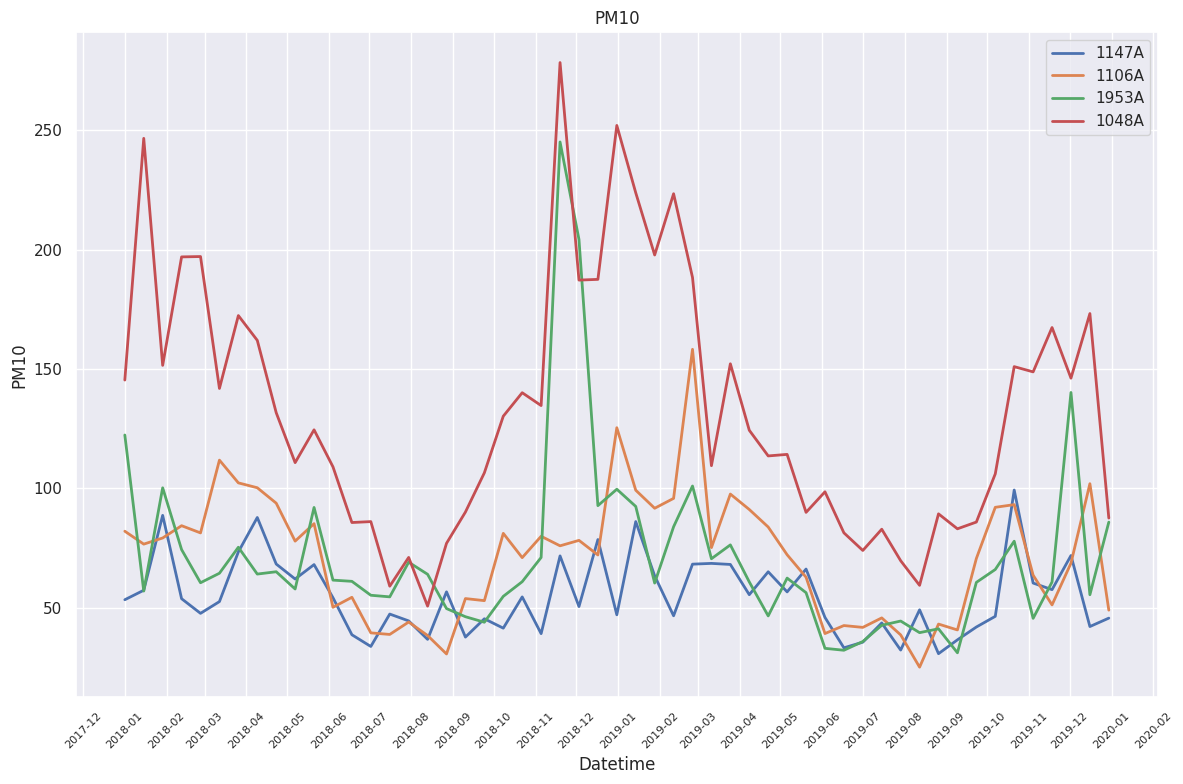

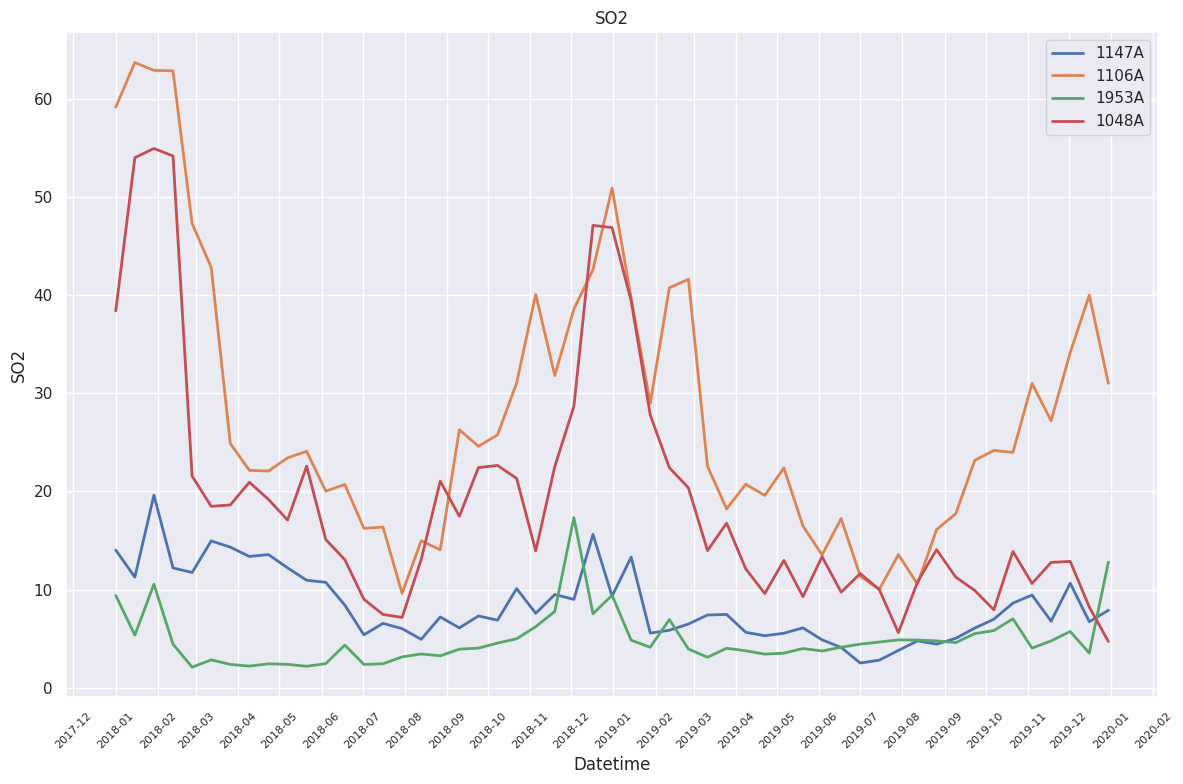

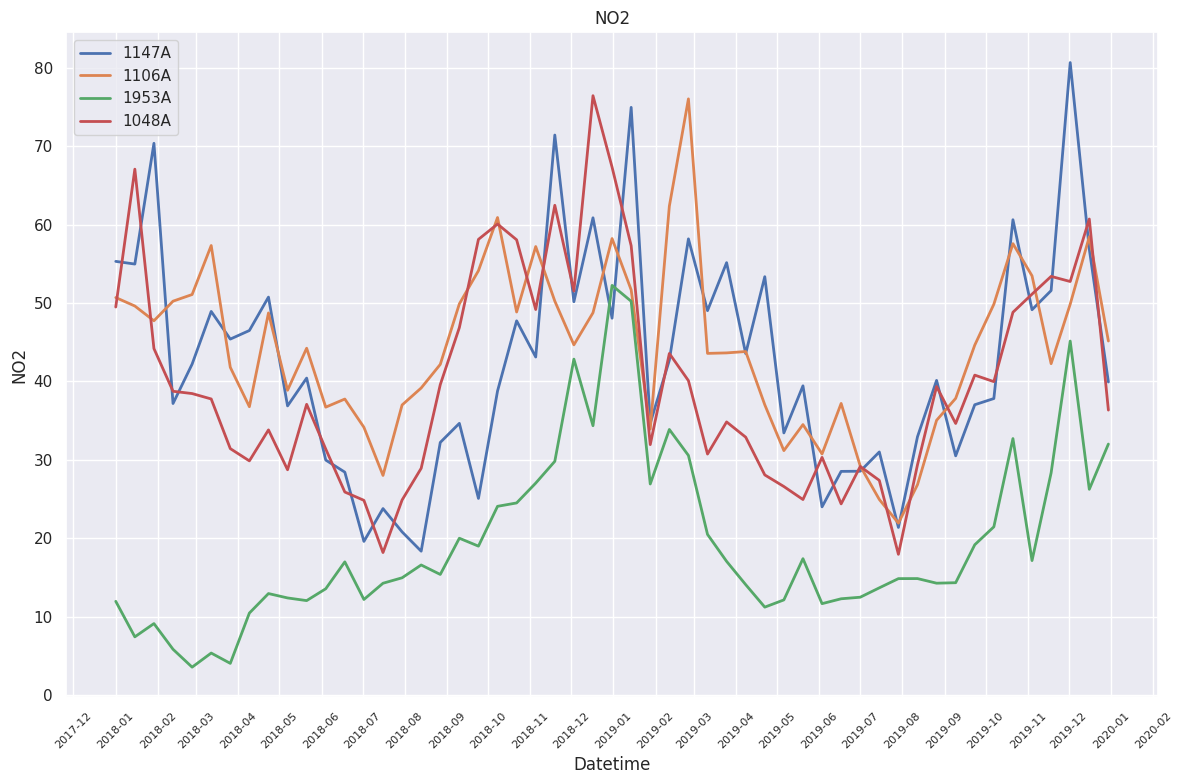

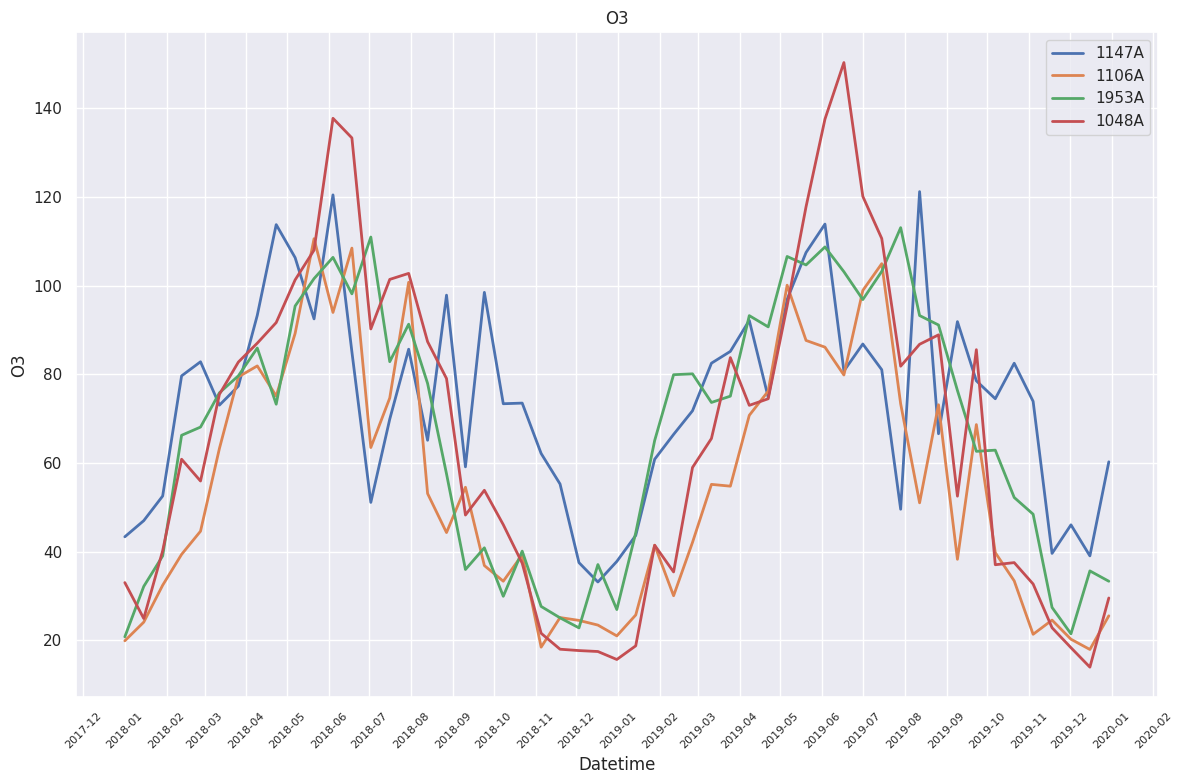

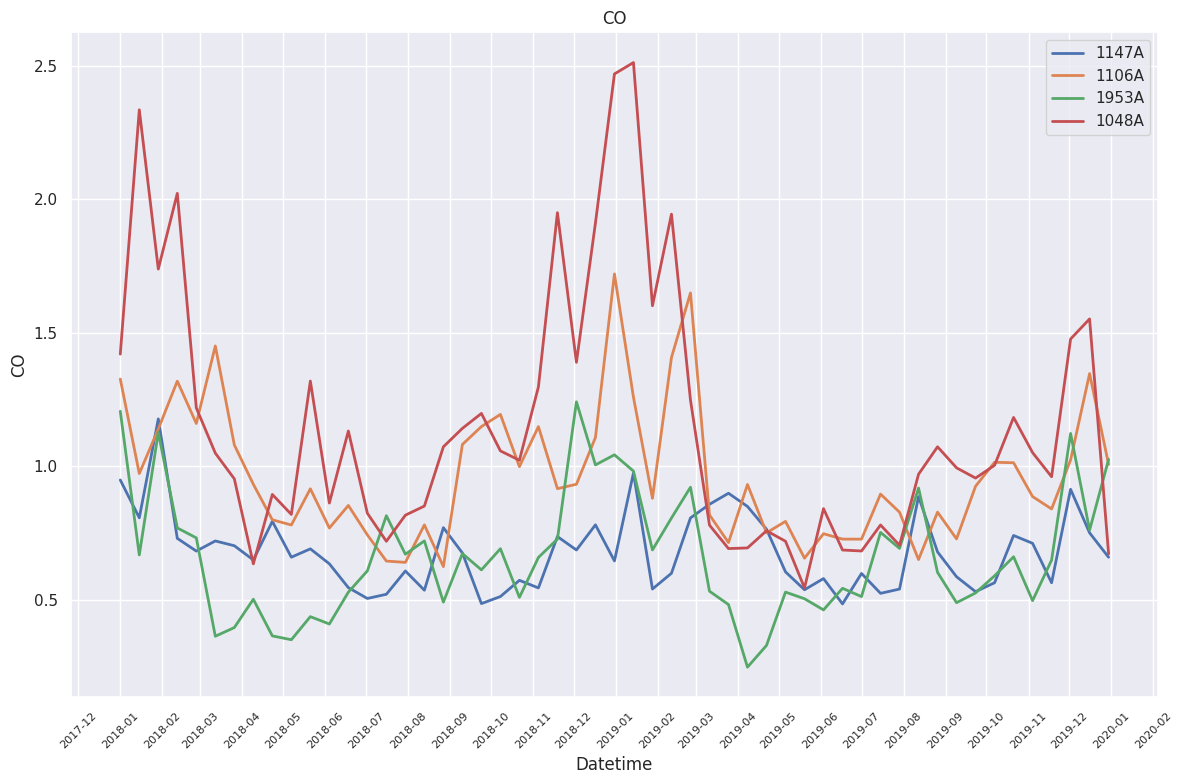

In [11]:

features = ['AQI', 'PM2.5', 'PM10',  
            'SO2', 'NO2',  'O3',  'CO', ]
import plotly.express as px
import plotly.graph_objects as go
#px.box(df_temp, x='month_year', y='meantp')
sns.set_style('darkgrid')
#sns.set_theme(style="whitegrid")  # 设置样式
import matplotlib.dates as mdates
df_list = [pd.read_csv(os.path.join(fn, f"{file}.csv"), index_col=False) for file in station_list]


for f in features:
    plt.figure(figsize=(12, 8))
    for idx,df in enumerate(df_list):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df1 = df.set_index('datetime')
        df1 = df1.resample('14d').mean()
        sns.lineplot(x=df1.index, y=df1[f],label=station_list[idx], linewidth=2)
    #fig = px.line(df1, x='datetime', y = f)
    plt.title(f)
    plt.xlabel('Datetime')
    plt.ylabel(f)
    # 设置 x 轴的日期格式
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 每月一个刻度
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 格式化为年月

    plt.xticks(rotation=45,fontsize=8)
    plt.tight_layout()
    plt.savefig(f"./picture/1147A-{f}.jpg")
    #fig.show()
    plt.show()
